In this notebook we explain how do we implement the SABR stochastic volatility model, and how to plot the implied volatility curve based on SABR models. We shall also review how to calibrate a model to the market data.

First, we shall implement the SABR model. The implied Black volatility of the SABR model is given by
  \begin{equation*}
    \begin{split}
      &\sigma_{\mbox{SABR}}(F_0, K, \alpha, \beta, \rho, \nu) \\
      &= \frac{\alpha}{(F_0K)^{(1-\beta)/2}\left\{ 1 + \frac{(1-\beta)^2}{24}\log^2\left(\frac{F_0}{K}\right) + \frac{(1-\beta)^4}{1920}\log^4\left(\frac{F_0}{K}\right) + \cdots\right\} } \\
      &\;\;\;\times \frac{z}{x(z)} \times \left\{ 1 + \left[
          \frac{(1-\beta)^2}{24}
          \frac{\alpha^2}{(F_0K)^{1-\beta}}+\frac{1}{4}\frac{\rho\beta\nu\alpha}{(F_0K)^{(1-\beta)/2}}+\frac{2-3\rho^2}{24}\nu^2\right]
        T + \cdots \right.
    \end{split}
  \end{equation*}
  where
  \begin{equation*}
    \begin{split}
      z = \frac{\nu}{\alpha} (F_0K)^{(1-\beta)/2}
      \log\left(\frac{F_0}{K}\right),
    \end{split}
  \end{equation*}
  and
  \begin{equation*}
    \begin{split}
      x(z) = \log \left[ \frac{\sqrt{1-2\rho z+z^2}+z -\rho}{1-\rho}
      \right].
    \end{split}
  \end{equation*}


This can be implemented in Python as follows:

For each strike, the mid price is calculated as

\begin{equation*}
\begin{split}
\mbox{Mid Price} = \frac{\mbox{Best Bid} + \mbox{Best Ask}}{2}
\end{split}
\end{equation*}

In [1]:
%autosave 30
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pylab as plt
from tqdm.notebook import tqdm
import datetime as dt
from scipy.interpolate import interp1d
import seaborn as sns; sns.set(rc = {'figure.figsize' : (16,10)})
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

Autosaving every 30 seconds


To plot the implied volatility smile for the normal (Bachelier) model, just replaced the "BlackScholesCall" with the Bachelier formula.

Next, we look at the SABR model. The definition above contains the function

\begin{equation*}
\begin{split}
\mbox{SABR}(F, K, T, \alpha, \beta, \rho, \nu)
\end{split}
\end{equation*}

The function returns a volatility $\sigma_{\mbox{SABR}}$ for the Black76Lognormal call or put option formula, so that

\begin{equation*}
\begin{split}
\mbox{Call price} &= \mbox{BlackScholesCall}(S, K, r, \sigma_{\mbox{SABR}}, T) \\
\mbox{Put price} &= \mbox{BlackScholesPut}(S, K, r, \sigma_{\mbox{SABR}}, T) \\
\end{split}
\end{equation*}

How do we determine the parameters $\alpha$, $\rho$ and $\nu$?
- We choose them so that the output of the SABR model matches the implied volatilities observed in the market.
- We refer to this process as "model calibration".

In other words, defining

  \begin{equation*}
    \begin{split}
      \sigma_{\mbox{Mkt}}(K_1) - \mbox{SABR}(F, K_1, T, \alpha, 0.8, \rho, \nu) &= \epsilon_1 \\
      \sigma_{\mbox{Mkt}}(K_2) - \mbox{SABR}(F, K_2, T, \alpha, 0.8, \rho, \nu) &= \epsilon_2 \\
      \vdots&\\
      \sigma_{\mbox{Mkt}}(K_n) - \mbox{SABR}(F, K_n, T, \alpha, 0.8, \rho, \nu) &= \epsilon_n \\
    \end{split}
  \end{equation*}

We want to minimize the sum of squared error terms as follows:
  
  \begin{equation*}
    \begin{split}
      \min_{\substack{\alpha,\; \rho,\; \nu}} \;\sum_{i=1}^n \epsilon_i^2
    \end{split}
  \end{equation*}

We use the "least_squares" algorithm in "scipy" package to calibrate the SABR model parameters:


In [2]:
from scipy.optimize import least_squares

beta = 0.7

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err


def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalCall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol


def BlackScholesLognormalCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


def BlackScholesLognormalPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)


# SPX options implied volatility

In [3]:
dr = pd.read_csv('zero_rates_20201201.csv')
df = pd.read_csv('SPX_options.csv')
S = 3662.45
today = dt.date(2020,12,1)
expiries = [pd.Timestamp(str(x)).date() for x in df['exdate'].unique()]
T = [(exdate - today).days / 365.0 for exdate in expiries]

x = [13, 49, 77, 104]
y = [dr['rate'][1], dr['rate'][2], dr['rate'][3], dr['rate'][4]]

f = interp1d(x, y)
r17 = float(f(17))/100
r45 = float(f(45))/100
r80 = float(f(80))/100
df['cp_flag'] = df['cp_flag'].apply(lambda x: 'call' if x == 'C' else 'put')
df['price'] = (df['best_bid'] + df['best_offer']) / 2
df['duration'] = df['exdate'].apply(lambda x: (expiries[0] - today).days 
                                    if x == 20201218 
                                    else (expiries[1] - today).days if x == 20210115
                                    else (expiries[2] - today).days
                                   )


df['T'] = df['exdate'].apply(lambda x: T[0] if x == 20201218 
                             else T[1] if x == 20210115 
                             else T[2]
                            )
df['r'] = df['duration'].apply(lambda x:
                              r17 if x == 17
                              else r45 if x == 45
                              else r80)
df['strike_price'] = df['strike_price']/1000
# use OTM options (i.e. high strike calls if K > F, and low strike puts if K < F)
df['Forward'] = S*np.exp(df['r']*df['T'])

for i in range(df.shape[0]):
    if df['cp_flag'][i] == 'call':
        if df['strike_price'][i] < df['Forward'][i]:
            df = df.drop(i)
    else:
        if df['strike_price'][i] > df['Forward'][i]:
            df  = df.drop(i)
df = df.reset_index(drop = True)       
impliedvol = []
for i in range(df.shape[0]):
    impliedvol.append(impliedVolatility(S, 
                                        df['strike_price'][i], 
                                        df['r'][i], 
                                        df['price'][i], 
                                        df['T'][i], 
                                        df['cp_flag'][i]
                                       )
                     )
df['impliedvol'] = impliedvol
days17 = df[df['exdate'] == 20201218].reset_index(drop = True)
days45 = df[df['exdate'] == 20210115].reset_index(drop = True)
days80 = df[df['exdate'] == 20210219].reset_index(drop = True)

In [4]:
T17 = days17['T'][0]
F17 = days17['Forward'][0]
T45 = days45['T'][0]
F45 = days45['Forward'][0]
T80 = days80['T'][0]
F80 = days80['Forward'][0]
R17 = df['r'].unique()[0]
R45 = df['r'].unique()[1]
R80 = df['r'].unique()[2]

In [5]:
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              days17['strike_price'],
                                              days17['impliedvol'],
                                              F17,
                                              T17),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

C:\Users\user\AppData\Local\Temp/ipykernel_18900/1972538087.py:22: RuntimeWarning: invalid value encountered in double_scalars
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
C:\Users\user\AppData\Local\Temp/ipykernel_18900/1972538087.py:22: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


Calibrated SABR model parameters: alpha = 1.212, beta = 0.7, rho = -0.301, nu = 5.460


# Comparion of market volatilities vs SABR volatilities for options with 17 days duration

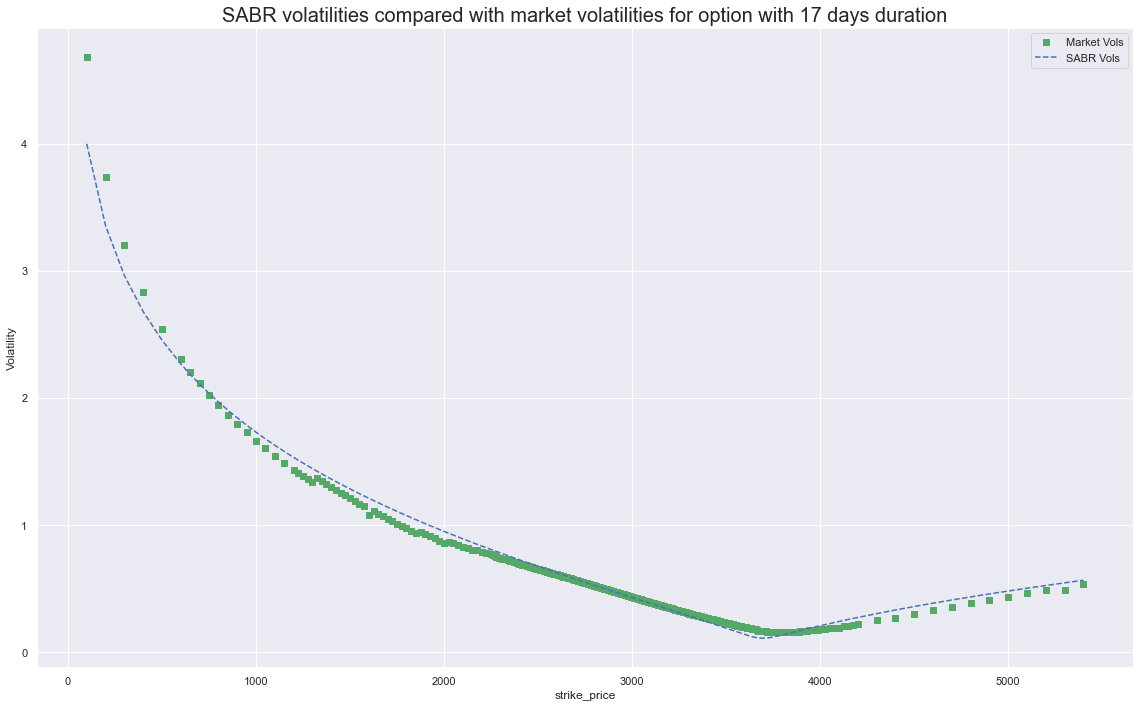

In [6]:
sabrvols = []
for K in days17['strike_price']:
    sabrvols.append(SABR(F17, K, T17, alpha, beta, rho, nu))

plt.figure(tight_layout=True)
plt.plot(days17['strike_price'], days17['impliedvol'], 'gs', label='Market Vols')
sns.lineplot(x = days17['strike_price'], y = sabrvols, label = 'SABR Vols', linestyle = '--')
plt.title('SABR volatilities compared with market volatilities for option with 17 days duration', fontsize = 20)
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Comparion of market volatilities vs SABR volatilities for options with 45 days duration

In [7]:
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              days45['strike_price'],
                                              days45['impliedvol'],
                                              F45,
                                              T45),
                    initialGuess)
alpha1 = res.x[0]
rho1 = res.x[1]
nu1 = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha1, beta, rho1, nu1))

C:\Users\user\AppData\Local\Temp/ipykernel_18900/1972538087.py:22: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
C:\Users\user\AppData\Local\Temp/ipykernel_18900/1972538087.py:22: RuntimeWarning: invalid value encountered in double_scalars
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


Calibrated SABR model parameters: alpha = 1.817, beta = 0.7, rho = -0.404, nu = 2.790


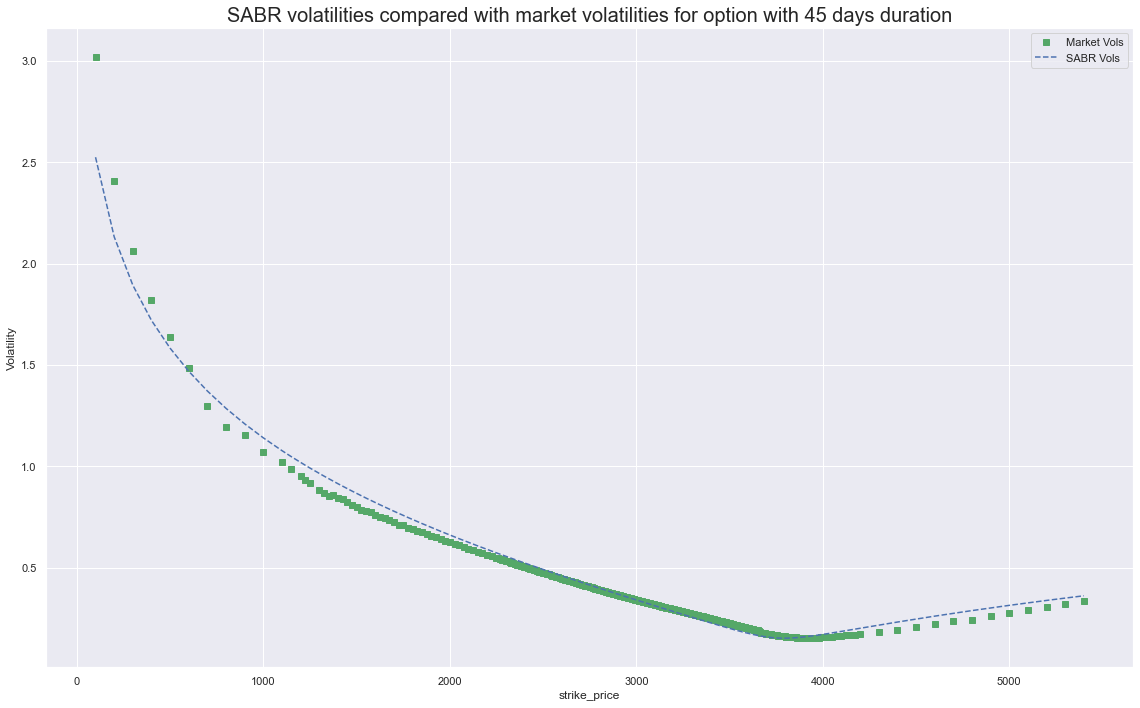

In [8]:
sabrvols1 = []
for K in days45['strike_price']:
    sabrvols1.append(SABR(F45, K, T45, alpha1, beta, rho1, nu1))

plt.figure(tight_layout=True)
plt.plot(days45['strike_price'], days45['impliedvol'], 'gs', label='Market Vols')
sns.lineplot(x = days45['strike_price'], y = sabrvols1, label = 'SABR Vols', linestyle = '--')
plt.title('SABR volatilities compared with market volatilities for option with 45 days duration', fontsize = 20)
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Comparion of market volatilities vs SABR volatilities for options with 80 days duration

In [9]:
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              days80['strike_price'],
                                              days80['impliedvol'],
                                              F80,
                                              T80),
                    initialGuess)
alpha2 = res.x[0]
rho2 = res.x[1]
nu2 = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha2, beta, rho2, nu2))

Calibrated SABR model parameters: alpha = 2.140, beta = 0.7, rho = -0.575, nu = 1.842


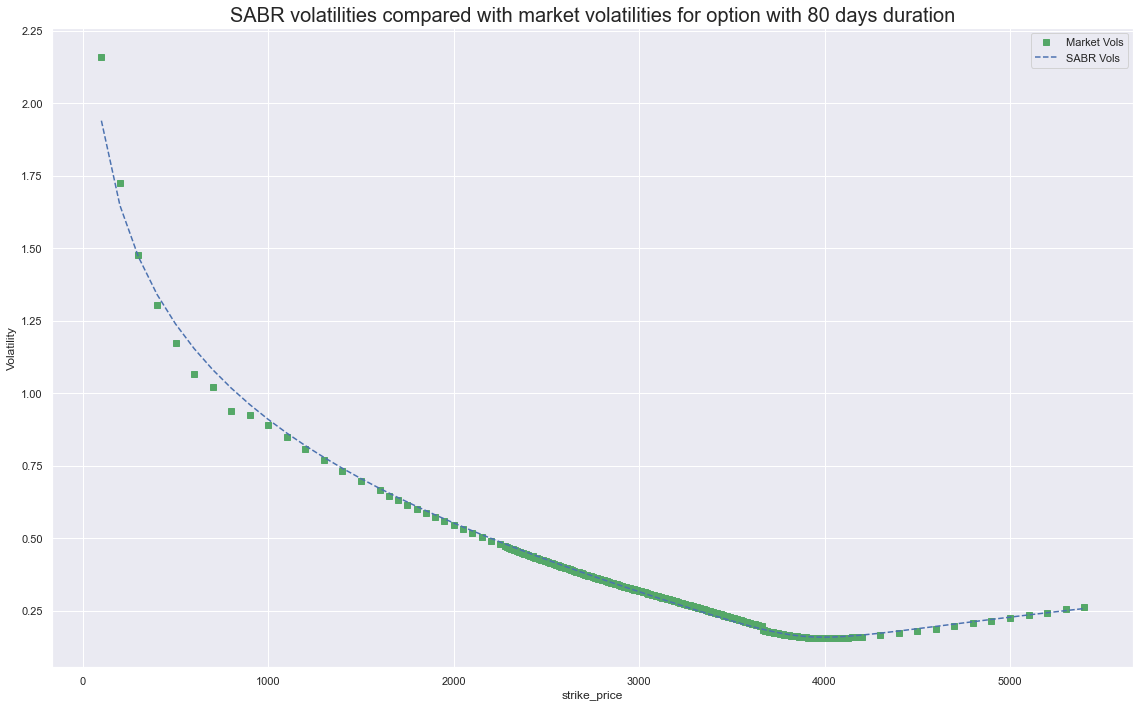

In [10]:
sabrvols2 = []
for K in days80['strike_price']:
    sabrvols2.append(SABR(F80, K, T80, alpha2, beta, rho2, nu2))

plt.figure(tight_layout=True)
plt.plot(days80['strike_price'], days80['impliedvol'], 'gs', label='Market Vols')
sns.lineplot(x = days80['strike_price'], y = sabrvols2, label = 'SABR Vols', linestyle = '--')
plt.title('SABR volatilities compared with market volatilities for option with 80 days duration', fontsize = 20)
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Diffusion Displaced Model Calibration

# Calibration for options with 17 days till expiration

In [11]:
def impliedCallVolatility(S, K, r, price, T):
    try:
        impliedVol = brentq(lambda x: price -
                        BlackScholesCall(S, K, r, x, T),
                        1e-6, 1)
    except Exception:
        impliedVol = np.nan

    return impliedVol

def impliedPutVolatility(S, K, r, price, T):
    try:
        impliedVol = brentq(lambda x: price -
                        BlackScholesPut(S, K, r, x, T),
                        1e-6, 1)
    except Exception:
        impliedVol = np.nan

    return impliedVol

def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def BlackScholesPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

def BachelierCall(S, K, r, sigma, T):
    d = (S-K) / (S*sigma*np.sqrt(T))
    disc = np.exp(-r*T)
    return disc*((S-K)*norm.cdf(d)+S*sigma*np.sqrt(T)*norm.pdf(d))

def BachelierPut(S, K, r, sigma, T):
    d = (S-K) / (S*sigma*np.sqrt(T))
    disc = np.exp(-r*T)
    return disc*((K-S)*norm.cdf(-d)+S*sigma*np.sqrt(T)*norm.pdf(-d))
def DisplacedDiffusionCall(S, K, r, sigma, T, beta):
    F = np.exp(r*T)*S
    c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
    c2 = c1 - beta*sigma*np.sqrt(T)
    return np.exp(-r*T)*(F/beta*norm.cdf(c1) - ((1-beta)/beta*F + K)*norm.cdf(c2))

def DisplacedDiffusionPut(S, K, r, sigma, T, beta):
    F = np.exp(r*T)*S
    c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
    c2 = c1 - beta*sigma*np.sqrt(T)
    return np.exp(-r*T)*(((1-beta)/beta*F + K)*norm.cdf(-c2) - F/beta*norm.cdf(-c1))

In [12]:

spx_df = pd.read_csv('SPX_options.csv')
spx_df['strike_price'] = spx_df['strike_price']/1000
spx_df['mid_price'] = (spx_df['best_bid'] + spx_df['best_offer'])/2


spx1 = spx_df[(spx_df.exdate == 20201218)]
spx2 = spx_df[(spx_df.exdate == 20210115)]
spx3 = spx_df[(spx_df.exdate == 20210219)]

S = 3662.45
K = 3660

beta1 = 0.8
beta2 = 0.6
beta3 = 0.4
beta4 = 0.2

T1 =T17
T2 = T45
T3 = T80
r1 = r17
r2 = r45
r3 = r80
## options with 17 days to expiration
atm_call1 = spx1[(spx1.strike_price == K)]
atm_call1 = atm_call1[(atm_call1.cp_flag == "C")]
atm_put1 = spx1[(spx1.strike_price == K)]
atm_put1 = atm_put1[(atm_put1.cp_flag == "P")]
sigma_call1 = impliedCallVolatility(S, K, r1 , atm_call1.mid_price, T1)
sigma_put1 = impliedPutVolatility(S, K, r1, atm_put1.mid_price, T1)
sigma1 = (sigma_call1 + sigma_put1)/2

## At The Money Volatility (ExDate: 2021/1/15)
atm_call2 = spx2[(spx2.strike_price == K)]
atm_call2 = atm_call2[(atm_call2.cp_flag == "C")]
atm_put2 = spx2[(spx2.strike_price == K)]
atm_put2 = atm_put2[(atm_put2.cp_flag == "P")]
sigma_call2 = impliedCallVolatility(S, K, r2 , atm_call2.mid_price, T2)
sigma_put2 = impliedPutVolatility(S, K, r2, atm_put2.mid_price, T2)
sigma2 = (sigma_call2 + sigma_put2)/2

## At The Money Volatility (ExDate: 2021/2/19)
atm_call3 = spx3[(spx3.strike_price == K)]
atm_call3 = atm_call3[(atm_call3.cp_flag == "C")]
atm_put3 = spx3[(spx3.strike_price == K)]
atm_put3 = atm_put3[(atm_put3.cp_flag == "P")]
sigma_call3 = impliedCallVolatility(S, K, r3 , atm_call3.mid_price, T3)
sigma_put3 = impliedPutVolatility(S, K, r3, atm_put3.mid_price, T3)
sigma3 = (sigma_call3 + sigma_put3)/2
# Displaced-Diffusion Model
def DisplacedDiffusionCall(S, K, r, sigma, T, beta):
    F = np.exp(r*T)*S
    c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
    c2 = c1 - beta*sigma*np.sqrt(T)
    return np.exp(-r*T)*(F/beta*norm.cdf(c1) - ((1-beta)/beta*F + K)*norm.cdf(c2))

def DisplacedDiffusionPut(S, K, r, sigma, T, beta):
    F = np.exp(r*T)*S
    c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
    c2 = c1 - beta*sigma*np.sqrt(T)
    return np.exp(-r*T)*(((1-beta)/beta*F + K)*norm.cdf(-c2) - F/beta*norm.cdf(-c1))
# Displaced Diffusion Volatility (exdate1)
spx_call1 = spx1[(spx1.cp_flag == "C")].reset_index(drop=True)
spx_put1 = spx1[(spx1.cp_flag == "P")].reset_index(drop=True)
strike1 = spx_put1["strike_price"].values

summary1 = []
for i in range(len(spx_put1.index)):
    K = strike1[i]
    if K <= 3660:
        impliedvol_market = impliedPutVolatility(S, K, r1, spx_put1['mid_price'][i], T1)

        price_lognormal = BlackScholesPut(S, K, r1, sigma1, T1)
        impliedvol_lognormal = impliedPutVolatility(S, K, r1, price_lognormal, T1)

        price_normal = BachelierPut(S, K, r1, sigma1, T1)
        impliedvol_normal = impliedPutVolatility(S, K, r1, price_normal, T1)
    
        price_dd1 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r1, price_dd1, T1)
        
        price_dd2 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r1, price_dd2, T1)
        
        price_dd3 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r1, price_dd3, T1)
        
        price_dd4 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r1, price_dd4, T1)

    elif K > 3660:
        impliedvol_market = impliedCallVolatility(S, K, r1, spx_call1['mid_price'][i], T1)

        price_lognormal = BlackScholesCall(S, K, r1, sigma1, T1)
        impliedvol_lognormal = impliedCallVolatility(S, K, r1, price_lognormal, T1)

        price_normal = BachelierCall(S, K, r1, sigma1, T1)
        impliedvol_normal = impliedCallVolatility(S, K, r1, price_normal, T1)
       
        price_dd1 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r1, price_dd1, T1)
        
        price_dd2 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r1, price_dd2, T1)
        
        price_dd3 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r1, price_dd3, T1)
        
        price_dd4 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r1, price_dd4, T1)
        
    summary1.append([K, 
                    impliedvol_market, 
                    impliedvol_lognormal,
                    impliedvol_normal, 
                    impliedvol_dd1,
                    impliedvol_dd2,
                    impliedvol_dd3,
                    impliedvol_dd4,
                    ])
    
dd_1 = pd.DataFrame(summary1, columns=['strike', 
                                        'impliedvol_market',
                                        'impliedvol_lognormal', 
                                        'impliedvol_normal', 
                                        'impliedvol_dd1',
                                        'impliedvol_dd2',
                                        'impliedvol_dd3',
                                        'impliedvol_dd4'
                                        ])

In [13]:
sigma1,sigma2,sigma3

(0.1750985704585507, 0.1853718842874737, 0.1909732726819409)

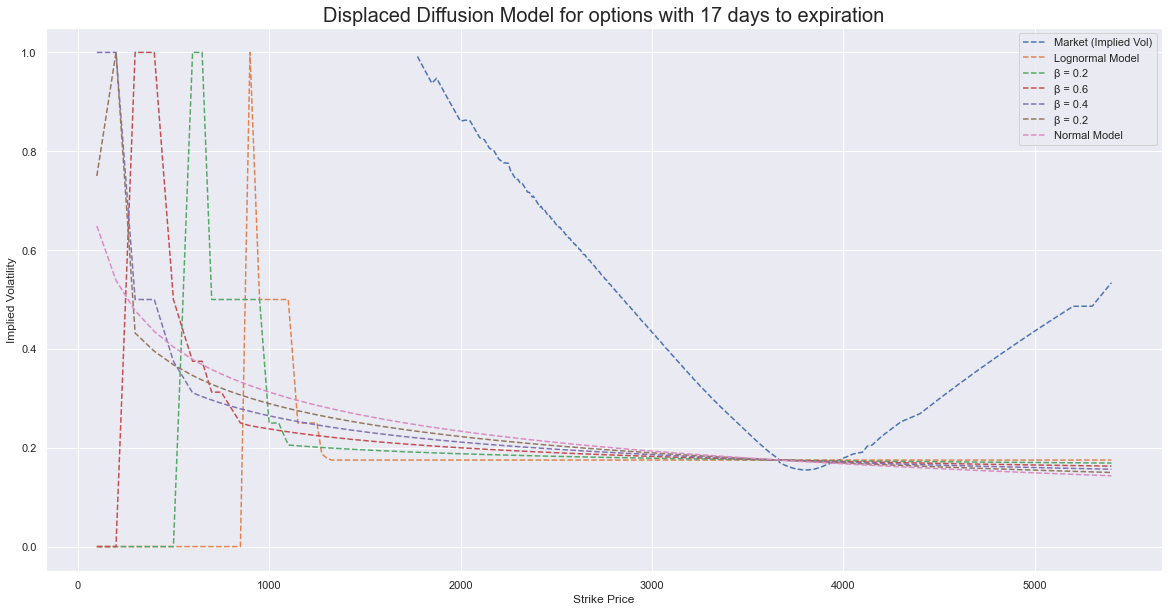

In [14]:
plt.figure(figsize=(20 , 10))
plt.plot(dd_1['strike'],dd_1['impliedvol_market'],label='Market (Implied Vol)', linestyle="dashed")
plt.plot(dd_1['strike'],dd_1['impliedvol_lognormal'],label='Lognormal Model', linestyle="dashed")
plt.plot(dd_1['strike'],dd_1['impliedvol_dd1'],label='\u03B2 = 0.2', linestyle="dashed")
plt.plot(dd_1['strike'],dd_1['impliedvol_dd2'],label='\u03B2 = 0.6', linestyle="dashed")
plt.plot(dd_1['strike'],dd_1['impliedvol_dd3'],label='\u03B2 = 0.4', linestyle="dashed")
plt.plot(dd_1['strike'],dd_1['impliedvol_dd4'],label='\u03B2 = 0.2', linestyle="dashed")
plt.plot(dd_1['strike'],dd_1['impliedvol_normal'],label='Normal Model', linestyle="dashed")

plt.title('Displaced Diffusion Model for options with 17 days to expiration', fontsize = 20)
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')

plt.legend()
plt.show()

# Calibration for options with 45 days till expiration

In [15]:
spx_call2 = spx2[(spx2.cp_flag == "C")].reset_index(drop=True)
spx_put2 = spx2[(spx2.cp_flag == "P")].reset_index(drop=True)
strike2 = spx_put2["strike_price"].values

summary2 = []
for i in range(len(spx_put2.index)):
    K = strike2[i]
    if K <= 3660:
        impliedvol_market = impliedPutVolatility(S, K, r2, spx_put2['mid_price'][i], T2)

        price_lognormal = BlackScholesPut(S, K, r2, sigma2, T2)
        impliedvol_lognormal = impliedPutVolatility(S, K, r2, price_lognormal, T2)

        price_normal = BachelierPut(S, K, r2, sigma2, T2)
        impliedvol_normal = impliedPutVolatility(S, K, r2, price_normal, T2)
    
        price_dd1 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r2, price_dd1, T2)
        
        price_dd2 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r2, price_dd2, T2)
        
        price_dd3 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r2, price_dd3, T2)
        
        price_dd4 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r2, price_dd4, T2)

    elif K > 3660:
        impliedvol_market = impliedCallVolatility(S, K, r2, spx_call2['mid_price'][i], T2)

        price_lognormal = BlackScholesCall(S, K, r2, sigma2, T2)
        impliedvol_lognormal = impliedCallVolatility(S, K, r2, price_lognormal, T2)

        price_normal = BachelierCall(S, K, r2, sigma2, T2)
        impliedvol_normal = impliedCallVolatility(S, K, r2, price_normal, T2)
       
        price_dd1 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r2, price_dd1, T2)
        
        price_dd2 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r2, price_dd2, T2)
        
        price_dd3 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r2, price_dd3, T2)
        
        price_dd4 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r2, price_dd4, T2)
        
    summary2.append([K, 
                    impliedvol_market, 
                    impliedvol_lognormal,
                    impliedvol_normal, 
                    impliedvol_dd1,
                    impliedvol_dd2,
                    impliedvol_dd3,
                    impliedvol_dd4,
                    ])
    
dd_2 = pd.DataFrame(summary2, columns=['strike', 
                                        'impliedvol_market',
                                        'impliedvol_lognormal', 
                                        'impliedvol_normal', 
                                        'impliedvol_dd1',
                                        'impliedvol_dd2',
                                        'impliedvol_dd3',
                                        'impliedvol_dd4'
                                        ])

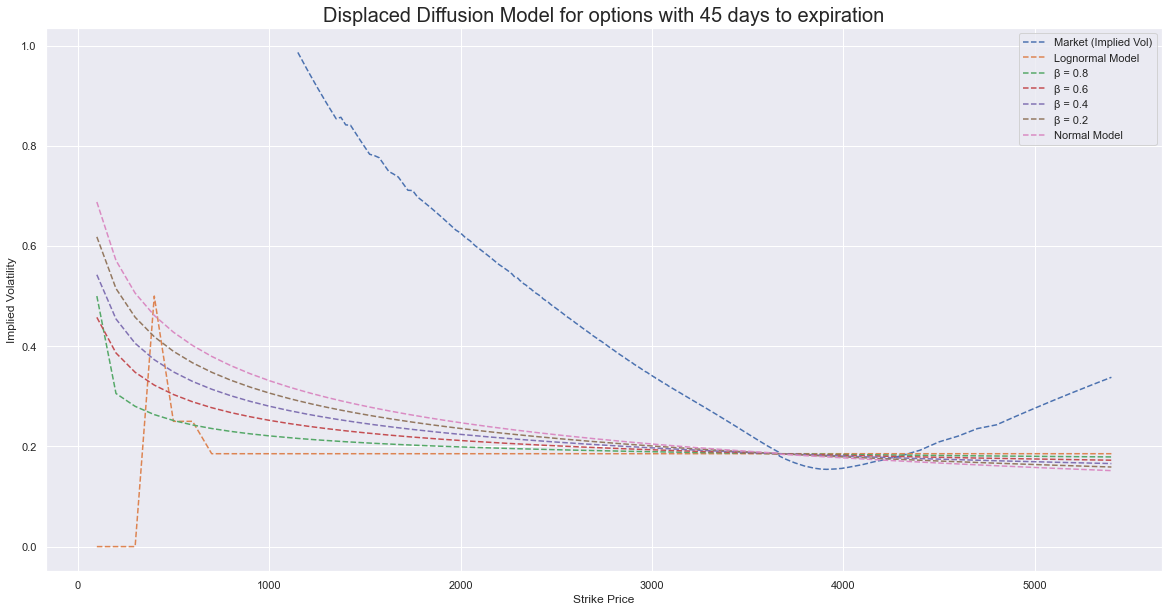

In [16]:
plt.figure(figsize=(20 , 10))
plt.plot(dd_2['strike'],dd_2['impliedvol_market'],label='Market (Implied Vol)', linestyle="dashed")
plt.plot(dd_2['strike'],dd_2['impliedvol_lognormal'],label='Lognormal Model', linestyle="dashed")
plt.plot(dd_2['strike'],dd_2['impliedvol_dd1'],label='β = 0.8', linestyle="dashed")
plt.plot(dd_2['strike'],dd_2['impliedvol_dd2'],label='β = 0.6', linestyle="dashed")
plt.plot(dd_2['strike'],dd_2['impliedvol_dd3'],label='β = 0.4', linestyle="dashed")
plt.plot(dd_2['strike'],dd_2['impliedvol_dd4'],label='β = 0.2', linestyle="dashed")
plt.plot(dd_2['strike'],dd_2['impliedvol_normal'],label='Normal Model', linestyle="dashed")

plt.title('Displaced Diffusion Model for options with 45 days to expiration', fontsize = 20)
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')

plt.legend()
plt.show()

# Calibration for options with 80 days till expiration

In [17]:
# Displaced Diffusion Volatility (exdate3)
spx_call3 = spx3[(spx3.cp_flag == "C")].reset_index(drop=True)
spx_put3 = spx3[(spx3.cp_flag == "P")].reset_index(drop=True)
strike3 = spx_put3["strike_price"].values

summary3 = []
for i in range(len(spx_put3.index)):
    K = strike3[i]
    if K <= 3660:
        impliedvol_market = impliedPutVolatility(S, K, r3, spx_put3['mid_price'][i], T3)

        price_lognormal = BlackScholesPut(S, K, r3, sigma3, T3)
        impliedvol_lognormal = impliedPutVolatility(S, K, r3, price_lognormal, T3)

        price_normal = BachelierPut(S, K, r3, sigma3, T3)
        impliedvol_normal = impliedPutVolatility(S, K, r3, price_normal, T3)
    
        price_dd1 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r3, price_dd1, T3)
        
        price_dd2 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r3, price_dd2, T3)
        
        price_dd3 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r3, price_dd3, T3)
        
        price_dd4 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r3, price_dd4, T3)

    elif K > 3660:
        impliedvol_market = impliedCallVolatility(S, K, r3, spx_call3['mid_price'][i], T3)

        price_lognormal = BlackScholesCall(S, K, r3, sigma3, T3)
        impliedvol_lognormal = impliedCallVolatility(S, K, r3, price_lognormal, T3)

        price_normal = BachelierCall(S, K, r3, sigma3, T3)
        impliedvol_normal = impliedCallVolatility(S, K, r3, price_normal, T3)
       
        price_dd1 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r3, price_dd1, T3)
        
        price_dd2 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r3, price_dd2, T3)
        
        price_dd3 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r3, price_dd3, T3)
        
        price_dd4 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r3, price_dd4, T3)
        
    summary3.append([K, 
                    impliedvol_market, 
                    impliedvol_lognormal,
                    impliedvol_normal, 
                    impliedvol_dd1,
                    impliedvol_dd2,
                    impliedvol_dd3,
                    impliedvol_dd4,
                    ])
    
dd_3 = pd.DataFrame(summary3, columns=['strike', 
                                        'impliedvol_market',
                                        'impliedvol_lognormal', 
                                        'impliedvol_normal', 
                                        'impliedvol_dd1',
                                        'impliedvol_dd2',
                                        'impliedvol_dd3',
                                        'impliedvol_dd4'
                                        ])

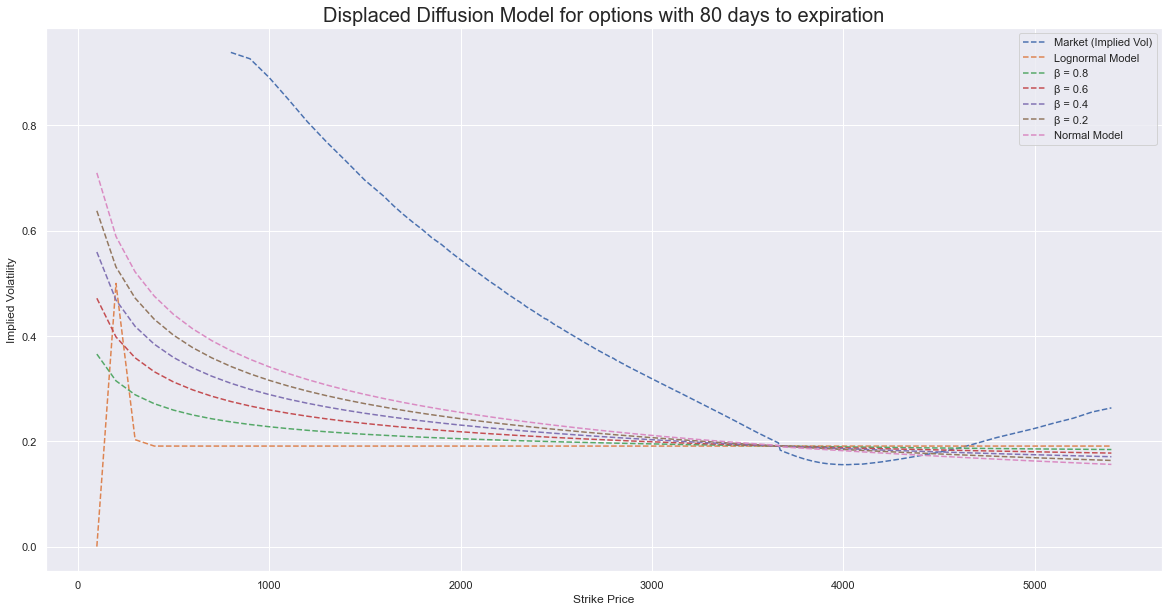

In [18]:
plt.figure(figsize=(20 , 10))
plt.plot(dd_3['strike'],dd_3['impliedvol_market'],label='Market (Implied Vol)', linestyle="dashed")
plt.plot(dd_3['strike'],dd_3['impliedvol_lognormal'],label='Lognormal Model', linestyle="dashed")
plt.plot(dd_3['strike'],dd_3['impliedvol_dd1'],label='β = 0.8', linestyle="dashed")
plt.plot(dd_3['strike'],dd_3['impliedvol_dd2'],label='β = 0.6', linestyle="dashed")
plt.plot(dd_3['strike'],dd_3['impliedvol_dd3'],label='β = 0.4', linestyle="dashed")
plt.plot(dd_3['strike'],dd_3['impliedvol_dd4'],label='β = 0.2', linestyle="dashed")
plt.plot(dd_3['strike'],dd_3['impliedvol_normal'],label='Normal Model', linestyle="dashed")

plt.title('Displaced Diffusion Model for options with 80 days to expiration', fontsize = 20)
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')

plt.legend()
plt.show()

# SPY options Implied volatility

In [19]:
#american call and put option

In [20]:
def american_implied_vol(S0, K, T, r, otype, price,days):

    impliedVol = brentq(lambda x: price - CRR_american_option_value(S0, K, T, r, x, otype, days),
                        1e-12, 10.0)
    return impliedVol  

In [21]:
import math
def CRR_american_option_value(S0, K, T, r, sigma, otype, days):
    # generate binomial tree
    if days == 0.04657534:
        M = 17
    elif days == 0.12328767:
        M = 45
    else:
        M = 80
    
    dt = T / M  # steps
    df = math.exp(-r * dt)  # discount per interval
    inf = math.exp(r * dt)  # discount per interval

    # initialize udp
    u = math.exp(sigma * math.sqrt(dt))  # up movement
    d = 1 / u  # down movement
    q = (math.exp(r * dt) - d) / (u - d)  # martingale branch probability
    
    # initialize mu md
    mu = np.arange(M + 1)
    mu = np.resize(mu, (M + 1, M + 1))
    md = np.transpose(mu)
    
    # 计算个节点单向变动时的股票价格
    mus = u ** (mu - md)
    mds = d ** md
    
    # 得到各节点的股票价格
    S = S0 * mus * mds 
        
    # 二.计算每个节点股票的预期价格
    mes = S0 * inf ** mu

    # 三.得到叶子结点的期权价值
    if otype == 'call':
        V = np.maximum(S - K, 0)     
        #计算每个节点提前行权的收益
        oreturn = mes - K
    else:
        V = np.maximum(K - S, 0)       
        #计算每个节点提前行权的收益
        oreturn = K - mes

    # 四.逐步向前加权平均折现和提前行权的收益比较，得到期初期权价值
    for z in range(0, M):  # backwards iteration
        #计算后期折现的后期价格
        ovalue = (q * V[0:M - z, M - z] +
                         (1 - q) * V[1:M - z + 1, M - z]) * df
        #逐列更新期权价值，相当于二叉树中的逐层向前折算
        #期权价格取后期折现和提前行权获得收益的最大值
        V[0:M - z, M - z - 1] = np.maximum(ovalue, oreturn[0:M - z, M - z - 1])
        
    return V[0, 0]

In [22]:
dr = pd.read_csv('zero_rates_20201201.csv')
df = pd.read_csv('SPY_options.csv')
S0 = 366.02
today = dt.date(2020,12,1)
expiries = [pd.Timestamp(str(x)).date() for x in df['exdate'].unique()]
T = [(exdate - today).days / 365.0 for exdate in expiries]

x = [13, 49, 77, 104]
y = [dr['rate'][1], dr['rate'][2], dr['rate'][3], dr['rate'][4]]

f = interp1d(x, y)
r17 = float(f(17))/100
r45 = float(f(45))/100
r80 = float(f(80))/100
df['cp_flag'] = df['cp_flag'].apply(lambda x: 'call' if x == 'C' else 'put')
df['price'] = (df['best_bid'] + df['best_offer']) / 2
df['duration'] = df['exdate'].apply(lambda x: (expiries[0] - today).days 
                                    if x == 20201218 
                                    else (expiries[1] - today).days if x == 20210115
                                    else (expiries[2] - today).days
                                   )


df['T'] = df['exdate'].apply(lambda x: T[0] if x == 20201218 
                             else T[1] if x == 20210115 
                             else T[2]
                            )
df['r'] = df['duration'].apply(lambda x:
                              r17 if x == 17
                              else r45 if x == 45
                              else r80)
df['strike_price'] = df['strike_price']/1000
# use OTM options (i.e. high strike calls if K > F, and low strike puts if K < F)
df['Forward'] = S0*np.exp(df['r']*df['T'])

for i in range(df.shape[0]):
    if df['cp_flag'][i] == 'call':
        if df['strike_price'][i] < df['Forward'][i]:
            df = df.drop(i)
    else:
        if df['strike_price'][i] > df['Forward'][i]:
            df  = df.drop(i)
df = df.reset_index(drop = True)       

In [23]:
impliedvol = []
for i in range(df.shape[0]):
    impliedvol.append(american_implied_vol(S0, 
                                           df['strike_price'][i],
                                           df['T'][i],
                                           df['r'][i],
                                           df['cp_flag'][i],
                                           df['price'][i],
                                           df['T'][i])
                     )
df['impliedvol'] = impliedvol
days17 = df[df['exdate'] == 20201218].reset_index(drop = True)
days45 = df[df['exdate'] == 20210115].reset_index(drop = True)
days80 = df[df['exdate'] == 20210219].reset_index(drop = True)

In [24]:
T17 = days17['T'][0]
F17 = days17['Forward'][0]
T45 = days45['T'][0]
F45 = days45['Forward'][0]
T80 = days80['T'][0]
F80 = days80['Forward'][0]
R17 = df['r'].unique()[0]
R45 = df['r'].unique()[1]
R80 = df['r'].unique()[2]

In [25]:
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              days17['strike_price'],
                                              days17['impliedvol'],
                                              F17,
                                              T17),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

Calibrated SABR model parameters: alpha = 0.645, beta = 0.7, rho = -0.409, nu = 5.358


# Comparion of market volatilities vs SABR volatilities for options with 17 days duration

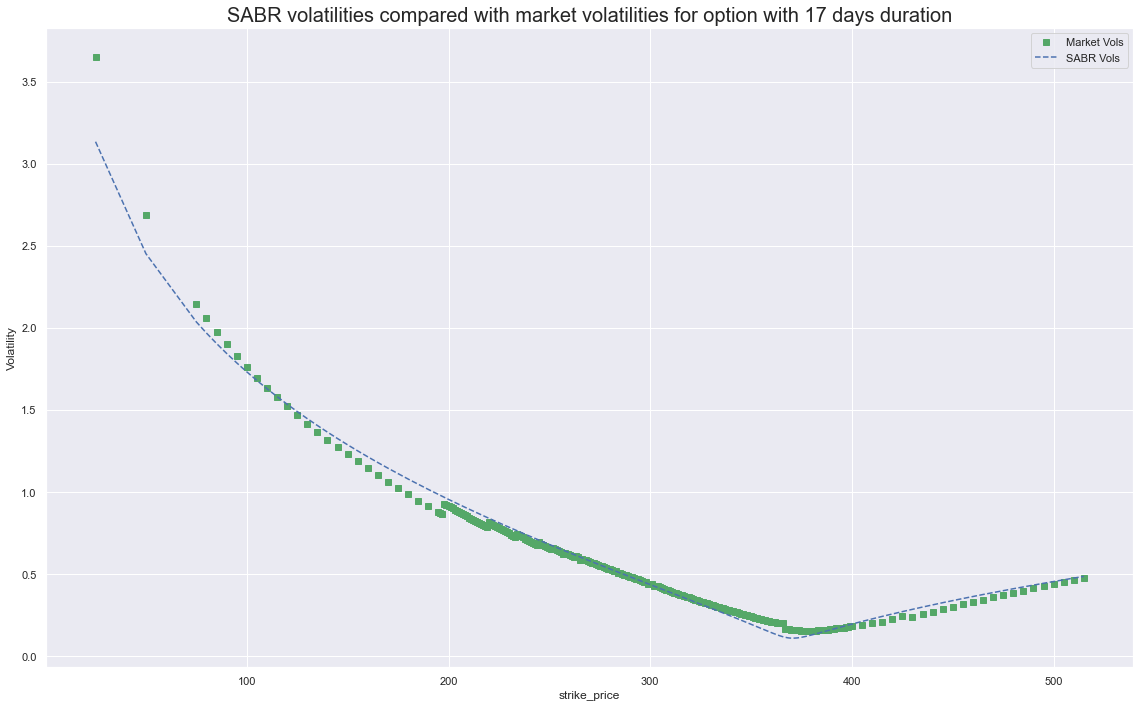

In [26]:
sabrvols = []
for K in days17['strike_price']:
    sabrvols.append(SABR(F17, K, T17, alpha, beta, rho, nu))

plt.figure(tight_layout=True)
plt.plot(days17['strike_price'], days17['impliedvol'], 'gs', label='Market Vols')
sns.lineplot(x = days17['strike_price'], y = sabrvols, label = 'SABR Vols', linestyle = '--')
plt.title('SABR volatilities compared with market volatilities for option with 17 days duration', fontsize = 20)
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Comparion of market volatilities vs SABR volatilities for options with 45 days duration

In [27]:
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              days45['strike_price'],
                                              days45['impliedvol'],
                                              F45,
                                              T45),
                    initialGuess)
alpha1 = res.x[0]
rho1 = res.x[1]
nu1 = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha1, beta, rho1, nu1))

Calibrated SABR model parameters: alpha = 0.896, beta = 0.7, rho = -0.484, nu = 2.779


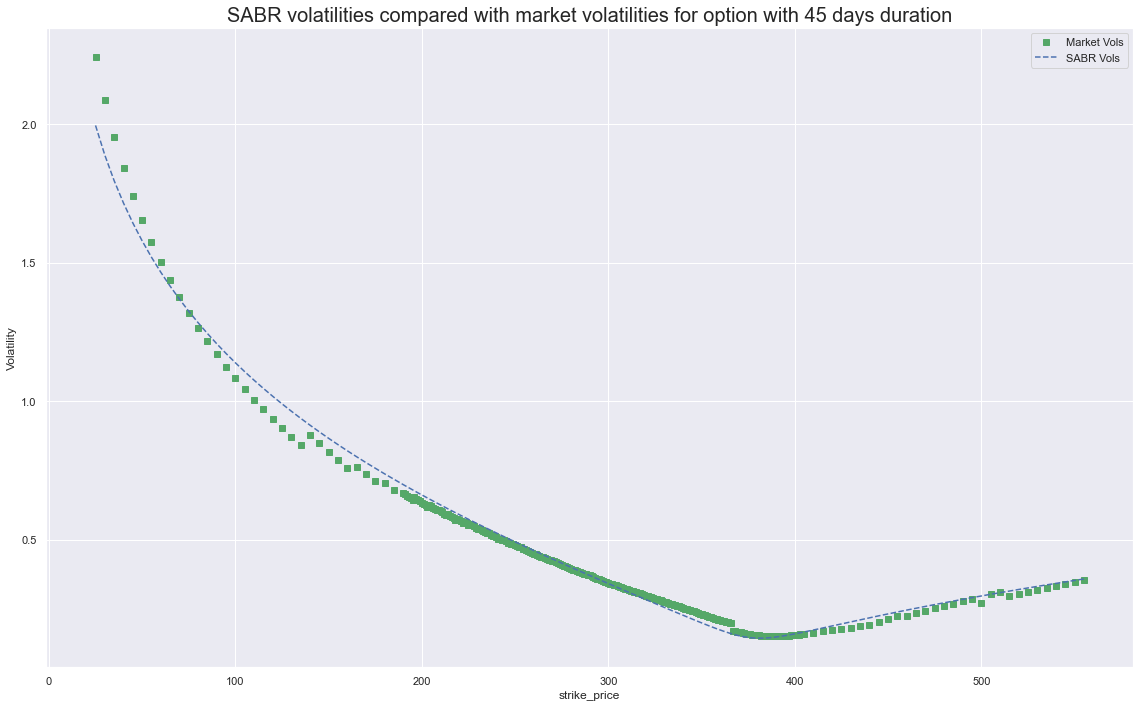

In [28]:
sabrvols1 = []
for K in days45['strike_price']:
    sabrvols1.append(SABR(F45, K, T45, alpha1, beta, rho1, nu1))

plt.figure(tight_layout=True)
plt.plot(days45['strike_price'], days45['impliedvol'], 'gs', label='Market Vols')
sns.lineplot(x = days45['strike_price'], y = sabrvols1, label = 'SABR Vols', linestyle = '--')
plt.title('SABR volatilities compared with market volatilities for option with 45 days duration', fontsize = 20)
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Comparion of market volatilities vs SABR volatilities for options with 80 days duration

In [29]:
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              days80['strike_price'],
                                              days80['impliedvol'],
                                              F80,
                                              T80),
                    initialGuess)
alpha2 = res.x[0]
rho2 = res.x[1]
nu2 = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha2, beta, rho2, nu2))

C:\Users\user\AppData\Local\Temp/ipykernel_18900/1972538087.py:22: RuntimeWarning: invalid value encountered in double_scalars
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


Calibrated SABR model parameters: alpha = 1.118, beta = 0.7, rho = -0.629, nu = 1.760


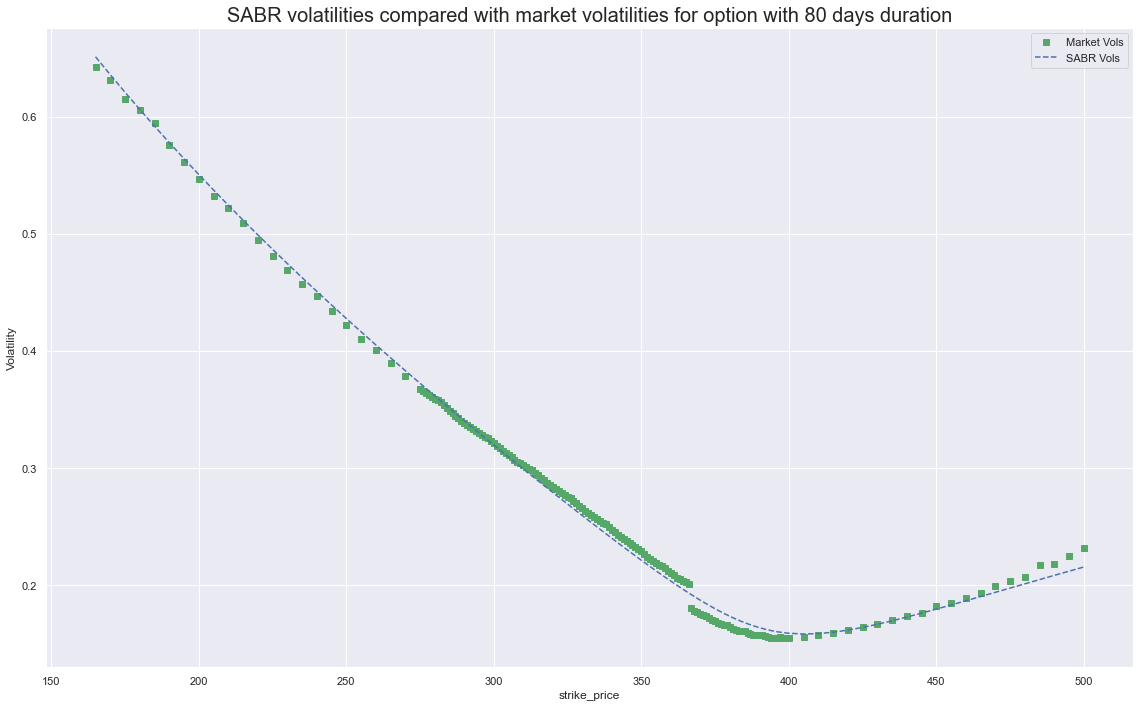

In [30]:
sabrvols2 = []
for K in days80['strike_price']:
    sabrvols2.append(SABR(F80, K, T80, alpha2, beta, rho2, nu2))

plt.figure(tight_layout=True)
plt.plot(days80['strike_price'], days80['impliedvol'], 'gs', label='Market Vols')
sns.lineplot(x = days80['strike_price'], y = sabrvols2, label = 'SABR Vols', linestyle = '--')
plt.title('SABR volatilities compared with market volatilities for option with 80 days duration', fontsize = 20)
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Diffusion Displaced Model Calibration

# Calibration for options with 17 days till expiration

In [31]:
spx_df = pd.read_csv('SPY_options.csv')
spx_df['strike_price'] = spx_df['strike_price']/1000
spx_df['mid_price'] = (spx_df['best_bid'] + spx_df['best_offer'])/2


spx1 = spx_df[(spx_df.exdate == 20201218)]
spx2 = spx_df[(spx_df.exdate == 20210115)]
spx3 = spx_df[(spx_df.exdate == 20210219)]

S = 366.02
K = 366

beta1 = 0.8
beta2 = 0.6
beta3 = 0.4
beta4 = 0.2

T1 = T17
T2 = T45
T3 = T80

r1 = r17
r2 = r45
r3 = r80

## atm1
atm_call1 = spx1[(spx1.strike_price == K)]
atm_call1 = atm_call1[(atm_call1.cp_flag == "C")]
atm_put1 = spx1[(spx1.strike_price == K)]
atm_put1 = atm_put1[(atm_put1.cp_flag == "P")]
sigma_call1 = impliedCallVolatility(S, K, r1 , atm_call1.mid_price, T1)
sigma_put1 = impliedPutVolatility(S, K, r1, atm_put1.mid_price, T1)
sigma1 = (sigma_call1 + sigma_put1)/2

## atm2
atm_call2 = spx2[(spx2.strike_price == K)]
atm_call2 = atm_call2[(atm_call2.cp_flag == "C")]
atm_put2 = spx2[(spx2.strike_price == K)]
atm_put2 = atm_put2[(atm_put2.cp_flag == "P")]
sigma_call2 = impliedCallVolatility(S, K, r2 , atm_call2.mid_price, T2)
sigma_put2 = impliedPutVolatility(S, K, r2, atm_put2.mid_price, T2)
sigma2 = (sigma_call2 + sigma_put2)/2

## atm3
atm_call3 = spx3[(spx3.strike_price == K)]
atm_call3 = atm_call3[(atm_call3.cp_flag == "C")]
atm_put3 = spx3[(spx3.strike_price == K)]
atm_put3 = atm_put3[(atm_put3.cp_flag == "P")]
sigma_call3 = impliedCallVolatility(S, K, r3 , atm_call3.mid_price, T3)
sigma_put3 = impliedPutVolatility(S, K, r3, atm_put3.mid_price, T3)
sigma3 = (sigma_call3 + sigma_put3)/2

def DisplacedDiffusionCall(S, K, r, sigma, T, beta):
    F = np.exp(r*T)*S
    c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
    c2 = c1 - beta*sigma*np.sqrt(T)
    return np.exp(-r*T)*(F/beta*norm.cdf(c1) - ((1-beta)/beta*F + K)*norm.cdf(c2))

def DisplacedDiffusionPut(S, K, r, sigma, T, beta):
    F = np.exp(r*T)*S
    c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
    c2 = c1 - beta*sigma*np.sqrt(T)
    return np.exp(-r*T)*(((1-beta)/beta*F + K)*norm.cdf(-c2) - F/beta*norm.cdf(-c1))

spx_call1 = spx1[(spx1.cp_flag == "C")].reset_index(drop=True)
spx_put1 = spx1[(spx1.cp_flag == "P")].reset_index(drop=True)
strike1 = spx_put1["strike_price"].values

summary1 = []
for i in range(len(spx_put1.index)):
    K = strike1[i]
    if K <= 366:
        impliedvol_market = impliedPutVolatility(S, K, r1, spx_put1['mid_price'][i], T1)

        price_lognormal = BlackScholesPut(S, K, r1, sigma1, T1)
        impliedvol_lognormal = impliedPutVolatility(S, K, r1, price_lognormal, T1)

        price_normal = BachelierPut(S, K, r1, sigma1, T1)
        impliedvol_normal = impliedPutVolatility(S, K, r1, price_normal, T1)
    
        price_dd1 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r1, price_dd1, T1)
        
        price_dd2 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r1, price_dd2, T1)
        
        price_dd3 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r1, price_dd3, T1)
        
        price_dd4 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r1, price_dd4, T1)

    elif K > 366:
        impliedvol_market = impliedCallVolatility(S, K, r1, spx_call1['mid_price'][i], T1)

        price_lognormal = BlackScholesCall(S, K, r1, sigma1, T1)
        impliedvol_lognormal = impliedCallVolatility(S, K, r1, price_lognormal, T1)

        price_normal = BachelierCall(S, K, r1, sigma1, T1)
        impliedvol_normal = impliedCallVolatility(S, K, r1, price_normal, T1)
       
        price_dd1 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r1, price_dd1, T1)
        
        price_dd2 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r1, price_dd2, T1)
        
        price_dd3 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r1, price_dd3, T1)
        
        price_dd4 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r1, price_dd4, T1)
        
    summary1.append([K, 
                    impliedvol_market, 
                    impliedvol_lognormal,
                    impliedvol_normal, 
                    impliedvol_dd1,
                    impliedvol_dd2,
                    impliedvol_dd3,
                    impliedvol_dd4,
                    ])
    
dd_1 = pd.DataFrame(summary1, columns=['strike', 
                                        'impliedvol_market',
                                        'impliedvol_lognormal', 
                                        'impliedvol_normal', 
                                        'impliedvol_dd1',
                                        'impliedvol_dd2',
                                        'impliedvol_dd3',
                                        'impliedvol_dd4'
                                        ])

In [32]:
sigma1,sigma2,sigma3

(0.18669031698628016, 0.1848115441954425, 0.1910813478308737)

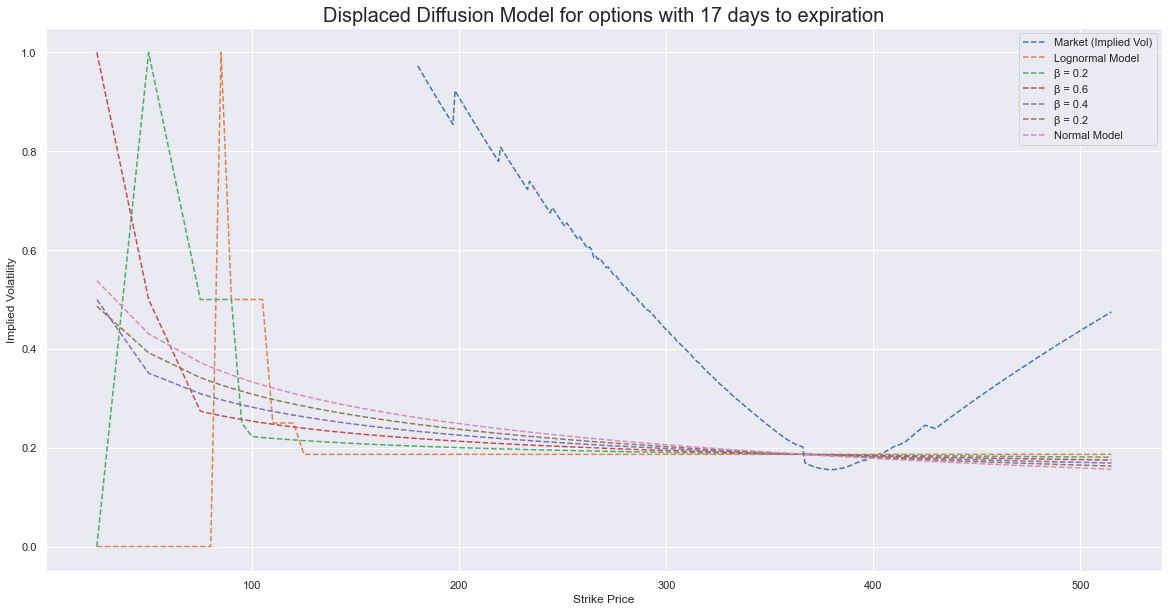

In [33]:
plt.figure(figsize=(20 , 10))
plt.plot(dd_1['strike'],dd_1['impliedvol_market'],label='Market (Implied Vol)', linestyle="dashed")
plt.plot(dd_1['strike'],dd_1['impliedvol_lognormal'],label='Lognormal Model', linestyle="dashed")
plt.plot(dd_1['strike'],dd_1['impliedvol_dd1'],label='\u03B2 = 0.2', linestyle="dashed")
plt.plot(dd_1['strike'],dd_1['impliedvol_dd2'],label='\u03B2 = 0.6', linestyle="dashed")
plt.plot(dd_1['strike'],dd_1['impliedvol_dd3'],label='\u03B2 = 0.4', linestyle="dashed")
plt.plot(dd_1['strike'],dd_1['impliedvol_dd4'],label='\u03B2 = 0.2', linestyle="dashed")
plt.plot(dd_1['strike'],dd_1['impliedvol_normal'],label='Normal Model', linestyle="dashed")

plt.title('Displaced Diffusion Model for options with 17 days to expiration', fontsize = 20)
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')

plt.legend()
plt.show()

# Calibration for options with 45 days till expiration

In [34]:
spx_call2 = spx2[(spx2.cp_flag == "C")].reset_index(drop=True)
spx_put2 = spx2[(spx2.cp_flag == "P")].reset_index(drop=True)
strike2 = spx_put2["strike_price"].values

summary2 = []
for i in range(len(spx_put2.index)):
    K = strike2[i]
    if K <= 366:
        impliedvol_market = impliedPutVolatility(S, K, r2, spx_put2['mid_price'][i], T2)

        price_lognormal = BlackScholesPut(S, K, r2, sigma2, T2)
        impliedvol_lognormal = impliedPutVolatility(S, K, r2, price_lognormal, T2)

        price_normal = BachelierPut(S, K, r2, sigma2, T2)
        impliedvol_normal = impliedPutVolatility(S, K, r2, price_normal, T2)
    
        price_dd1 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r2, price_dd1, T2)
        
        price_dd2 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r2, price_dd2, T2)
        
        price_dd3 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r2, price_dd3, T2)
        
        price_dd4 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r2, price_dd4, T2)

    elif K > 366:
        impliedvol_market = impliedCallVolatility(S, K, r2, spx_call2['mid_price'][i], T2)

        price_lognormal = BlackScholesCall(S, K, r2, sigma2, T2)
        impliedvol_lognormal = impliedCallVolatility(S, K, r2, price_lognormal, T2)

        price_normal = BachelierCall(S, K, r2, sigma2, T2)
        impliedvol_normal = impliedCallVolatility(S, K, r2, price_normal, T2)
       
        price_dd1 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r2, price_dd1, T2)
        
        price_dd2 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r2, price_dd2, T2)
        
        price_dd3 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r2, price_dd3, T2)
        
        price_dd4 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r2, price_dd4, T2)
        
    summary2.append([K, 
                    impliedvol_market, 
                    impliedvol_lognormal,
                    impliedvol_normal, 
                    impliedvol_dd1,
                    impliedvol_dd2,
                    impliedvol_dd3,
                    impliedvol_dd4,
                    ])
    
dd_2 = pd.DataFrame(summary2, columns=['strike', 
                                        'impliedvol_market',
                                        'impliedvol_lognormal', 
                                        'impliedvol_normal', 
                                        'impliedvol_dd1',
                                        'impliedvol_dd2',
                                        'impliedvol_dd3',
                                        'impliedvol_dd4'
                                        ])

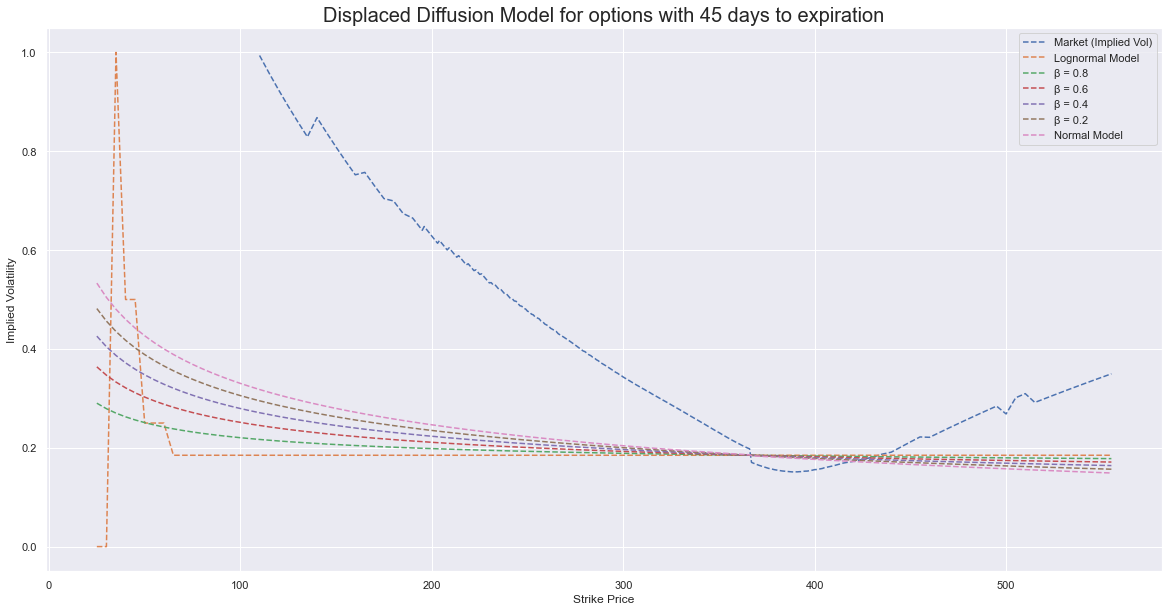

In [35]:
plt.figure(figsize=(20 , 10))
plt.plot(dd_2['strike'],dd_2['impliedvol_market'],label='Market (Implied Vol)', linestyle="dashed")
plt.plot(dd_2['strike'],dd_2['impliedvol_lognormal'],label='Lognormal Model', linestyle="dashed")
plt.plot(dd_2['strike'],dd_2['impliedvol_dd1'],label='β = 0.8', linestyle="dashed")
plt.plot(dd_2['strike'],dd_2['impliedvol_dd2'],label='β = 0.6', linestyle="dashed")
plt.plot(dd_2['strike'],dd_2['impliedvol_dd3'],label='β = 0.4', linestyle="dashed")
plt.plot(dd_2['strike'],dd_2['impliedvol_dd4'],label='β = 0.2', linestyle="dashed")
plt.plot(dd_2['strike'],dd_2['impliedvol_normal'],label='Normal Model', linestyle="dashed")

plt.title('Displaced Diffusion Model for options with 45 days to expiration', fontsize = 20)
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')

plt.legend()
plt.show()

# Calibration for options with 80 days till expiration

In [36]:

spx_call3 = spx3[(spx3.cp_flag == "C")].reset_index(drop=True)
spx_put3 = spx3[(spx3.cp_flag == "P")].reset_index(drop=True)
strike3 = spx_put3["strike_price"].values

summary3 = []
for i in range(len(spx_put3.index)):
    K = strike3[i]
    if K <= 366:
        impliedvol_market = impliedPutVolatility(S, K, r3, spx_put3['mid_price'][i], T3)

        price_lognormal = BlackScholesPut(S, K, r3, sigma3, T3)
        impliedvol_lognormal = impliedPutVolatility(S, K, r3, price_lognormal, T3)

        price_normal = BachelierPut(S, K, r3, sigma3, T3)
        impliedvol_normal = impliedPutVolatility(S, K, r3, price_normal, T3)
    
        price_dd1 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r3, price_dd1, T3)
        
        price_dd2 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r3, price_dd2, T3)
        
        price_dd3 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r3, price_dd3, T3)
        
        price_dd4 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r3, price_dd4, T3)

    elif K > 366:
        impliedvol_market = impliedCallVolatility(S, K, r3, spx_call3['mid_price'][i], T3)

        price_lognormal = BlackScholesCall(S, K, r3, sigma3, T3)
        impliedvol_lognormal = impliedCallVolatility(S, K, r3, price_lognormal, T3)

        price_normal = BachelierCall(S, K, r3, sigma3, T3)
        impliedvol_normal = impliedCallVolatility(S, K, r3, price_normal, T3)
       
        price_dd1 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r3, price_dd1, T3)
        
        price_dd2 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r3, price_dd2, T3)
        
        price_dd3 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r3, price_dd3, T3)
        
        price_dd4 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r3, price_dd4, T3)
        
    summary3.append([K, 
                    impliedvol_market, 
                    impliedvol_lognormal,
                    impliedvol_normal, 
                    impliedvol_dd1,
                    impliedvol_dd2,
                    impliedvol_dd3,
                    impliedvol_dd4,
                    ])
    
dd_3 = pd.DataFrame(summary3, columns=['strike', 
                                        'impliedvol_market',
                                        'impliedvol_lognormal', 
                                        'impliedvol_normal', 
                                        'impliedvol_dd1',
                                        'impliedvol_dd2',
                                        'impliedvol_dd3',
                                        'impliedvol_dd4'
                                        ])

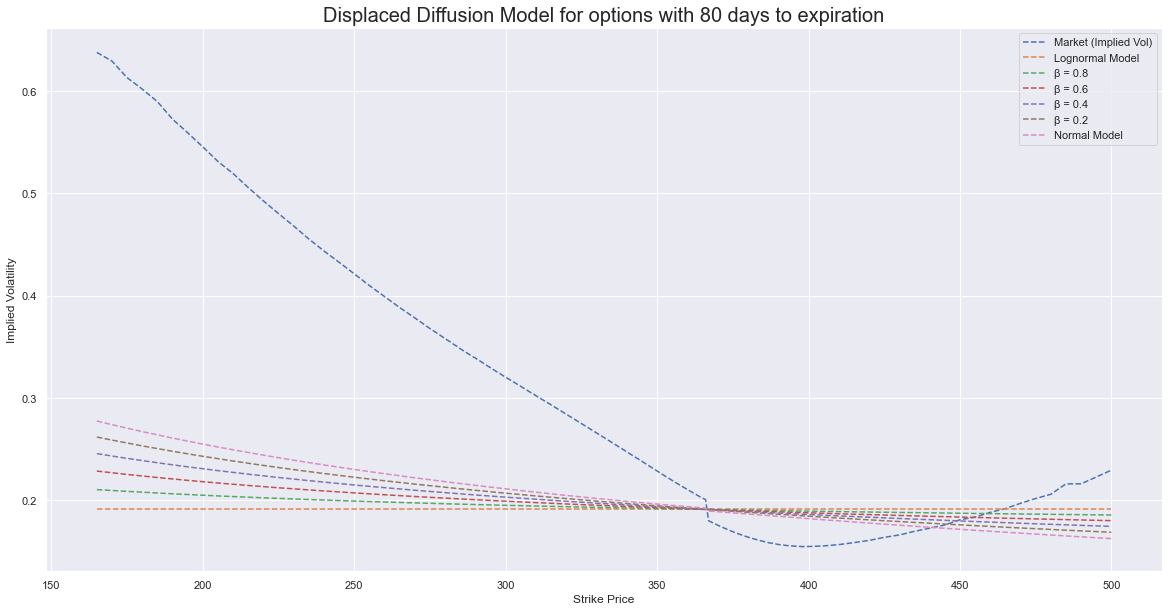

In [37]:
plt.figure(figsize=(20 , 10))
plt.plot(dd_3['strike'],dd_3['impliedvol_market'],label='Market (Implied Vol)', linestyle="dashed")
plt.plot(dd_3['strike'],dd_3['impliedvol_lognormal'],label='Lognormal Model', linestyle="dashed")
plt.plot(dd_3['strike'],dd_3['impliedvol_dd1'],label='β = 0.8', linestyle="dashed")
plt.plot(dd_3['strike'],dd_3['impliedvol_dd2'],label='β = 0.6', linestyle="dashed")
plt.plot(dd_3['strike'],dd_3['impliedvol_dd3'],label='β = 0.4', linestyle="dashed")
plt.plot(dd_3['strike'],dd_3['impliedvol_dd4'],label='β = 0.2', linestyle="dashed")
plt.plot(dd_3['strike'],dd_3['impliedvol_normal'],label='Normal Model', linestyle="dashed")

plt.title('Displaced Diffusion Model for options with 80 days to expiration', fontsize = 20)
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')

plt.legend()
plt.show()